# "Complex" LSTM Model

This notebook builds a more complex LSTM-RNN that takes a sequence of values of a predefined length as input and predicts the next value in the series, without taking into account any covariates.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Preparation

The dataset is read from a CSV file, and rows with a year greater than or equal to 2021 are filtered out.

In [8]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])
data = data[data['year'] < 2021]

The sequencing function is designed to generate sequences of data points for each country in the dataset. This function converts the time series data for each country into sequences of a specified length (sequence_length) and pairs these sequences with their corresponding target values.

In [9]:
def sequencing(data: pd.DataFrame, sequence_length: int): 
    

    sequences =  []
    targets = []
    country_list = []
    years = []


    # Create sequences for each country
    countries = data['iso3'].unique()
    for country in countries:
        data_trg = data[data['iso3'] == country]
        n = len(data_trg)
        data_ftr = data_trg.drop(["net_migration_tp1", "iso3", "set"], axis = 1)
        
        # Iterate from the end of the DataFrame to the beginning to create sequences
        for i in range(n - sequence_length + 1):
            # Extract the sequence of features and the target value
            country_list.append(country)
            years.append(data_ftr.iloc[(i + sequence_length)-1]['year'])
            data_ftr_tmp = data_ftr.drop(['year'], axis = 1)
            seq = data_ftr_tmp.iloc[i:i + sequence_length].values
            target = data_trg.iloc[(i + sequence_length)-1]['net_migration_tp1']
            sequences.append(seq)
            targets.append(target)



            
    sequences = torch.tensor(sequences, dtype = torch.float32)
    targets = torch.tensor(targets, dtype = torch.float32)

    df = [sequences, targets, country_list, years]

    return df


x = sequencing(data, 3)

/var/folders/dg/2g0zl_694mlgz8sg0tync7y00000gn/T/ipykernel_22993/1780944563.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  sequences = torch.tensor(sequences, dtype = torch.float32)


The train_val_test_split function splits the data into training, validation, and test sets. This is done by separating the sequences and targets into these three sets based on the years. The function first converts all data into NumPy arrays for easier slicing and then determines the indices for splitting the data. For each country, the function splits the sequences as follows:
- The last 7 sequences are used for the test set.
- The 3 sequences before the test set are used for the validation set.
- The remaining sequences are used for training.

Finally, the function converts the split data back into PyTorch tensors and wraps them in TensorDataset objects. These datasets are then loaded into DataLoader objects, which handle batching and shuffling during training.

In [10]:
def train_val_test_split(data_list):
    sequences, targets, country_list, years = data_list
    
    # Create separate lists for train, validation, and test splits
    train_sequences = []
    val_sequences = []
    test_sequences = []
    
    train_targets = []
    val_targets = []
    test_targets = []
    
    # Convert everything to numpy for easy slicing
    sequences = sequences.numpy()
    targets = targets.numpy()
    
    # Convert country_list and years to numpy arrays as well
    country_list = np.array(country_list)
    years = np.array(years)
    
    unique_countries = np.unique(country_list)
    
    for country in unique_countries:
        # Get all indices for this specific country
        country_indices = np.where(country_list == country)[0]
        
        # Split: last 7 for test, 3 before that for validation, and the rest for training
        train_idx = country_indices[:-8]
        val_idx = country_indices[-8:-5]
        test_idx = country_indices[-5:]
        
        # Append data to corresponding lists
        train_sequences.extend(sequences[train_idx])
        train_targets.extend(targets[train_idx])

        val_sequences.extend(sequences[val_idx])
        val_targets.extend(targets[val_idx])

        test_sequences.extend(sequences[test_idx])
        test_targets.extend(targets[test_idx])

    
    # Convert back to tensors
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
    
    train_targets = torch.tensor(train_targets, dtype=torch.float32)
    val_targets = torch.tensor(val_targets, dtype=torch.float32)
    test_targets = torch.tensor(test_targets, dtype=torch.float32)

    train_set = TensorDataset(train_sequences,train_targets)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

    val_set = TensorDataset(val_sequences,val_targets)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

    test_set = TensorDataset(test_sequences,test_targets)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = train_val_test_split(x)

### Model Building and Training

The LSTMModel class defines a neural network architecture that uses an LSTM layer followed by fully connected layers.

In [11]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


The LSTM model is instantiated with specific parameters for input size, hidden layer sizes, number of layers, and output size.

In [13]:
input_size = len(x[0][0][0])
hidden_size = 256
hidden_size2 = 128
num_layers = 3
output_size = 1 

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size)

The loss function used is the Huber Loss and the optimizer is Adam.

In [14]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/leafroitzheim/uni/deep_learning/.dl_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A checkpoint function is defined to save the model's state to a file, allowing for model recovery in case of interruptions or early stopping.

The restore_best_weights function reloads the model weights from the saved checkpoint file, ensuring the best performing model is used.

In [15]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

The EarlyStopping class is designed to stop training when the validation loss stops improving, which helps prevent overfitting.

In [18]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping()

The validate function evaluates the model on the validation set without updating the model's weights. 

In [19]:
def validate(model: LSTMModel, val_loader: DataLoader, criterion: nn.HuberLoss) -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for features, targets in val_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1)  
            loss = criterion(pred, targets)
            total_loss += loss.item()
    
    return total_loss


The train function manages the overall training process.

In [20]:
def train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, criterion: nn.HuberLoss) -> list:

    losses = []

    for epoch in range(epochs):

        # Train step

        model.train()

        epoch_train_loss = 0

        for features, targets in train_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1) 
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation step

        epoch_val_loss = validate(model, val_loader, criterion)

        stopper(epoch_val_loss)

        print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
        losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
        if stopper.counter == 0:
            checkpoint(model)
        
        if stopper.early_stop:
            print(f"Patience exceeded, stopping training & restoring best weights...")
            restore_best_weights(model)
            break
        


    return losses


Finally, the train function is called to train the model. It uses the previously defined LSTM model, training data, validation data, and the loss function. The training runs for a maximum of 100 epochs.

In [21]:
losses = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, criterion=criterion)

Epoch 1 done: Training loss: 8.2097, Validation loss: 0.0337, Patience counter: 0
Epoch 2 done: Training loss: 2.0249, Validation loss: 0.0239, Patience counter: 0
Epoch 3 done: Training loss: 1.9307, Validation loss: 0.0247, Patience counter: 1
Epoch 4 done: Training loss: 1.8972, Validation loss: 0.0313, Patience counter: 2
Epoch 5 done: Training loss: 1.8494, Validation loss: 0.0354, Patience counter: 3
Epoch 6 done: Training loss: 1.8367, Validation loss: 0.0281, Patience counter: 4
Epoch 7 done: Training loss: 1.6912, Validation loss: 0.0227, Patience counter: 0
Epoch 8 done: Training loss: 1.6150, Validation loss: 0.0290, Patience counter: 1
Epoch 9 done: Training loss: 1.5373, Validation loss: 0.0245, Patience counter: 2
Epoch 10 done: Training loss: 1.4595, Validation loss: 0.0207, Patience counter: 0
Epoch 11 done: Training loss: 1.3472, Validation loss: 0.0220, Patience counter: 1
Epoch 12 done: Training loss: 1.2558, Validation loss: 0.0203, Patience counter: 0
Epoch 13 done

### Evaluation

First, we consider the training curves:

<Axes: xlabel='epoch', ylabel='value'>

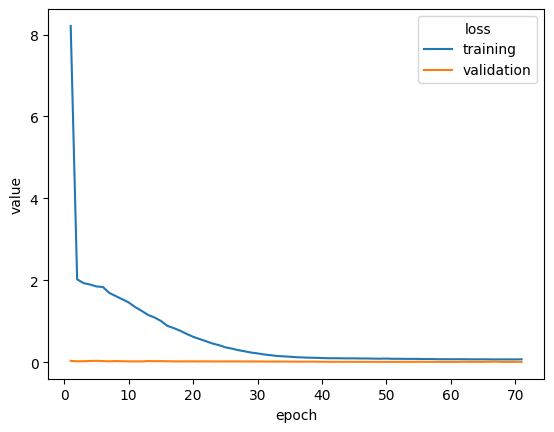

In [23]:
losses = pd.DataFrame(losses)

sns.lineplot(
    data=losses.melt(id_vars="epoch", var_name="loss"),
    x="epoch",
    y="value",
    hue="loss")

Then the metrics we will compare it to the benchmarks on:

In [25]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            targets = targets.unsqueeze(1)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics
metrics = eval(model, test_loader)
metrics

{'MSE': 0.0008244246087890454,
 'RMSE': 0.02871279521030729,
 'MAE': 0.011663475087569916}

The rescale function is used to transform the scaled predictions and actual values back to their original units. This is important when the model was trained on scaled data but the results need to be interpreted in the original units (e.g., the number of migrants).

In [26]:
# Manually selected from dataset

omin = -2290411 # PAK 2016
omax = 1866819 # USA 1997



scale = omax - omin

print(f"Metrics rescaled to original units:\n\nMSE: {metrics['MSE'] * (scale ** 2)}\nRMSE: {metrics['RMSE'] * scale}\nMAE: {metrics['MAE'] * scale}")

Metrics rescaled to original units:

MSE: 14248168816.283289
RMSE: 119365.69363214578
MAE: 48487.748538298285


The collect_predictions function runs the model on a given dataset and collects both the model's predictions and the actual target values. This function is used to gather the predicted and actual values for further analysis and visualization.

In [27]:
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

# Rescaling back to original units (migrants):

def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

In [28]:
predictions, actuals = collect_predictions(model, test_loader)
predictions, actuals = rescale(predictions, omin=omin, omax=omax), rescale(actuals, omin=omin, omax=omax)

The code then creates a scatter plot to compare the actual values against the predicted values from the test set.

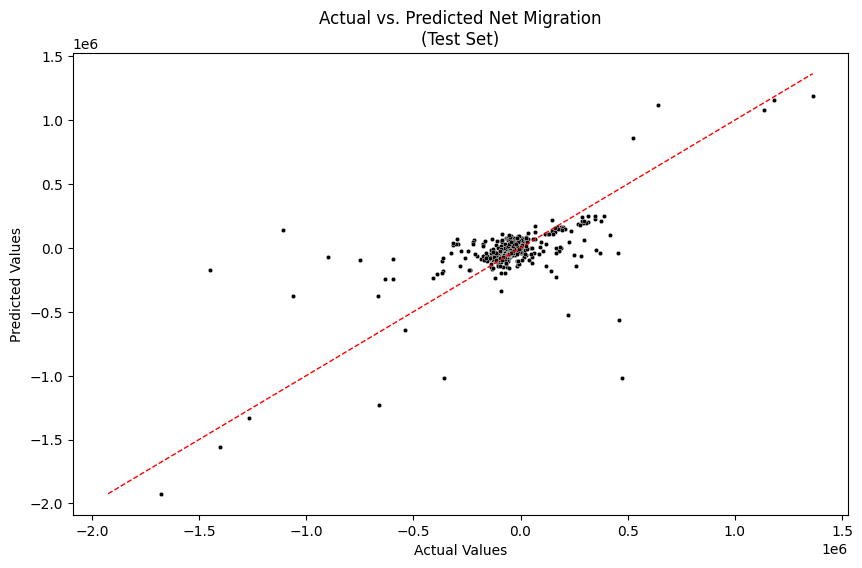

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()

Predictions and actual values from the training, validation, and test sets are combined into a single DataFrame called all_predictions. This DataFrame is used to create scatter plots that compare predicted and actual values for all three sets.

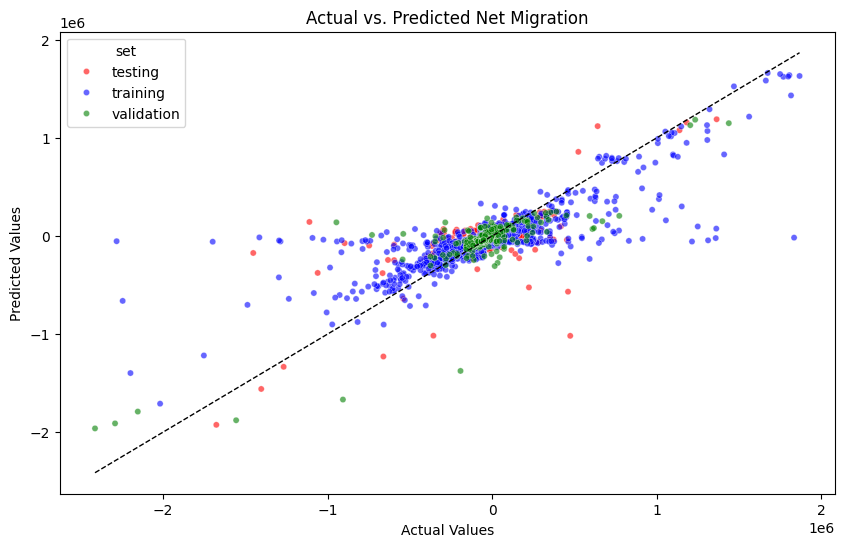

In [30]:
train_pred, train_act = collect_predictions(model, train_loader)
val_pred, val_act = collect_predictions(model, val_loader)

train_pred, train_act = rescale(train_pred, omin, omax), rescale(train_act, omin, omax)
val_pred, val_act = rescale(val_pred, omin, omax), rescale(val_act, omin, omax)

all_predictions = pd.concat([
    pd.DataFrame({"predicted": train_pred, "actual": train_act, "set": "training"}),
    pd.DataFrame({"predicted": val_pred, "actual": val_act, "set": "validation"}),
    pd.DataFrame({"predicted": predictions, "actual": actuals, "set": "testing"})
])

all_predictions['set'] = pd.Categorical(all_predictions['set'], categories=['testing', 'training', 'validation'])
all_predictions = all_predictions.sort_values('set').reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_predictions, 
    x="actual",
    y="predicted",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.6
)
# Main diagonal:
min_val = min(min(all_predictions["actual"]), min(all_predictions["predicted"]))
max_val = max(max(all_predictions["actual"]), max(all_predictions["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration')
plt.show()